## Turkish Biyology Asistant Chatbot (Deep Learning Project YZV302E)
### Fine-tuning and evaluation 

### Student Names

- **Ayah Hussein** — 150220917  
- **Oguzhan Celik** — 150210326


### Install Dependencies

In [ ]:
# Evaluation Metrics
pip install -q evaluate bert_score rouge_score

# LLM-as-a-Judge (m-Prometheus)
pip install -q prometheus-eval

# Fast Inference
pip install -q vllm

# Core Hugging Face Stack
pip install -q --upgrade transformers peft accelerate datasets trl

# Quantization
pip install -q bitsandbytes



### Import Libraries

In [ ]:
# Standard Library
import os
import re
import gc
import json
import random
import math

# Core ML / DL
import torch
import pandas as pd
import numpy as np

# Hugging Face & Transformers
from datasets import load_dataset
from transformers import (AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments)

# PEFT / LoRA / TRL
from peft import LoraConfig, get_peft_model, PeftModel
from trl import SFTTrainer

# Evaluation & Metrics
import evaluate
from scipy.stats import pearsonr
from prometheus_eval.prompts import ABSOLUTE_PROMPT

# Inference
from vllm import LLM, SamplingParams

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects

# Clustering 
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Utilities
from tqdm import tqdm
from tabulate import tabulate

# Colab 
from google.colab import drive


### Connet to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Fine-Tuning 

### Preparing the dataset for training

In [ ]:
# PATH TO DATA FOLDER
base_path ="/content/drive/MyDrive/Dl_project/Dataset/Dataset_old_cot/dataset_no_cot/"
data_files = {
    "train": base_path + "train_messages_no_cot.json", #All are in message format (suitable for fine tuning)
    "validation": base_path + "val_messages_no_cot.json",
    "test": base_path + "test_messages_no_cot.json"
}

# LOAD 
dataset = load_dataset("json", data_files=data_files)

train_ds = dataset["train"]
val_ds   = dataset["validation"]
test_ds  = dataset["test"]

# PRINT SIZES 
print("Train samples:", len(train_ds))
print("Validation samples:", len(val_ds))
print("Test samples:", len(test_ds))


### Training

In [ ]:
# Disable external logging tools
os.environ["WANDB_DISABLED"] = "true"

# Model ID (Gemma3-1B or Qwen2.5-1.5B)
model_id = "google/gemma-3-1b-it"

# Tokenizer Loading 
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" #GPUs require fixed-shape tensors

# 4-bit quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto"
)
model.config.use_cache = False
model.config.pretraining_tp = 1

def format_data_with_tokenizer(example):

    #Applies the Gemma tokenizer's chat template to the 'messages' column,
    #Example : <bos><start_of_turn>user(Question).<end_of_turn><start_of_turn>model .. 

    return {"text": tokenizer.apply_chat_template(example["messages"], tokenize=False)}

# Apply the formatting function to the training and validation splits
train_ds_formatted = train_ds.map(format_data_with_tokenizer, remove_columns=train_ds.column_names)
val_ds_formatted = val_ds.map(format_data_with_tokenizer, remove_columns=val_ds.column_names)

# Define and apply LoRA parameters
lora_config = LoraConfig(
    r=16, #8 
    lora_alpha=32, #16
    target_modules=["gate_proj", "up_proj", "down_proj", "q_proj", "o_proj", "v_proj", "k_proj"], #using All layers improved training
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/biology_finetune/gemma/dataset_new_cot_answers/cot_with_system_prompt",
    num_train_epochs=7,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    optim="paged_adamw_8bit",
    logging_steps=100, 
    learning_rate=2e-3, 
    bf16=True, 
    max_grad_norm=0.3,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    eval_strategy="steps",         
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    per_device_eval_batch_size=4,
)

# Initialize and run the SFTTrainer
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_formatted,
    eval_dataset=val_ds_formatted,
    processing_class=tokenizer,
    peft_config=lora_config,
)


### Start Training

In [ ]:
print("\nStarting Fine-tuning ..")
trainer.train()

# Save the final adapter weights
trainer.save_model("final_gemma_3b_lora_adapter_initial_data")
trainer.save_state("final_gemma_3b_lora_adapter_initial_data")


### Resume Training

In [ ]:
output_dir = "/content/drive/MyDrive/biology_finetune/gemma/model_double_questions_with_cot_NEW" 

CHECKPOINT_STEP = "2080"
checkpoint_path = os.path.join(output_dir, f"checkpoint-{CHECKPOINT_STEP}")

# Start training, resuming from the specified checkpoint
print(f"\nResuming Fine-tuning from: {checkpoint_path}")
trainer.train(resume_from_checkpoint=checkpoint_path)

# Save the final adapter weights after the continuation
trainer.save_model("final_gemma_3b_lora_adapter_cot_no_prompt_continued")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'pad_token_id': 1}.



Resuming Fine-tuning from: /content/drive/MyDrive/biology_finetune/gemma/model_double_questions_with_cot_NEW/checkpoint-2080


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
6,1.054300,1.291839,1.100655,1712708.000000,0.693096
7,1.005300,1.283017,1.066752,3425416.000000,0.695128
8,0.967900,1.290063,1.010111,5138124.000000,0.696837
9,0.927500,1.294965,0.985850,6850832.000000,0.697656
10,0.901000,1.301111,0.971084,8563540.000000,0.697547
11,0.897700,1.303176,0.965730,10276248.000000,0.697790
12,0.888900,1.305336,0.962371,11988956.000000,0.697625


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using

## Generating Answers for the test sets

### Generating the answers for test set using the base model


In [ ]:
# CONFIG
MODEL_ID = "Qwen/Qwen2.5-1.5B" # or "google/gemma-3-1b-it"
INPUT_FILE = "/content/drive/MyDrive/biology_finetune/gemma/dataset_new_cot_answers/test_raw.json"
OUTPUT_FILE = "test_with_Qwen_answers.json"
BATCH_SIZE = 32 

#LOAD MODEL
print(f"Loading {MODEL_ID}...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

#PREPARE DATA
with open(INPUT_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Generating for {len(data)} items in batches of {BATCH_SIZE}...")

#BATCHED GENERATION LOOP
for i in tqdm(range(0, len(data), BATCH_SIZE)):
    batch_items = data[i : i + BATCH_SIZE]
    batch_prompts = []

    for item in batch_items:
        messages = [
            {"role": "user", "content":  item['question']}
        ]

        # Apply template
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        batch_prompts.append(text)

    # Tokenize Batch
    inputs = tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,       # Pad short sequences to match the longest in the batch
        truncation=True,
        max_length=2048
    ).to(model.device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,  
            temperature=0.3,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )

    # 4. Decode Batch
    input_length = inputs.input_ids.shape[1]
    generated_tokens = outputs[:, input_length:]
    decoded_batch = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

    # Save results back to data
    for j, answer in enumerate(decoded_batch):
        # Map the answer back to the correct item in the main list
        data[i + j]['model_answer'] = answer.strip()

# SAVE
with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

print(f"Saved to {OUTPUT_FILE}")

### Generating the answers for the test set using fine_tuned model

In [ ]:
# CONFIG
adapter_path = "/content/drive/MyDrive/biology_finetune/gemma/dataset_new_cot_answers/cot_with_system_prompt/checkpoint-1100"      #gemma/dataset_new_cot_answers/cot_with_system_prompt/checkpoint-3000
base_model_id = "google/gemma-3-1b-it" #or "Qwen/Qwen2.5-1.5B"
input_file = "/content/drive/MyDrive/Dl_ project/Dataset/test_raw.json"
output_file = "test_gemma_initial_dataset_finetuned.json"
BATCH_SIZE = 32  # Process 32 items at once for speed.

# LOAD MODEL
print(f"1. Loading Base Model: {base_model_id}...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

print(f"2. Loading LoRA Adapter from: {adapter_path}...")
model = PeftModel.from_pretrained(base_model, adapter_path)

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(adapter_path)
tokenizer.padding_side = "left" #padding to the left for generating answers
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# LOAD DATA
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Starting Generation for {len(data)} items in batches of {BATCH_SIZE}...")

# BATCHED GENERATION LOOP 
for i in tqdm(range(0, len(data), BATCH_SIZE)):
    # 1. Create the batch
    batch_items = data[i : i + BATCH_SIZE]
    batch_prompts = []

    # Apply chat template to each item in the batch
    for item in batch_items:
        messages = [{"role": "user", "content": item['question']}]
        text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        batch_prompts.append(text)

    # Tokenize the batch
    inputs = tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,     
        truncation=True,
        max_length=2048
    ).to(model.device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.3,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id
        )

    # Decode and Save
    input_length = inputs.input_ids.shape[1]
    generated_tokens = outputs[:, input_length:]
    decoded_batch = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

    # Map answers back to original data objects
    for j, answer in enumerate(decoded_batch):
        data[i + j]['model_answer'] = answer.strip()

        # Optional: Print the first item of the batch to verify it's working
        if j == 0:
            print(f"\n[Batch Example] Q: {batch_items[j]['question'][:50]}...")

# SAVE
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

print(f"Saved results to {output_file}")

### Generate two test datasets one for each system prompt for the model trained with system prompt

In [ ]:
# CONFIG
adapter_path = "/content/drive/MyDrive/biology_finetune/gemma/dataset_new_cot_answers/cot_with_system_prompt/checkpoint-3000"
base_model_id = "google/gemma-3-1b-it"
input_file = "/content/drive/MyDrive/biology_finetune/gemma/dataset_new_cot_answers/test_raw.json"

# Intermediate File (Saved BEFORE generation)
intermediate_file = "test_cot_for_generation.json"

# Final Output File (Saved AFTER generation)
output_file = "test_cot_for_eval.json"

BATCH_SIZE = 32

# System Prompt
system_short = (
    "Sen bir biyoloji asistanısın. Soruyu açık, anlaşılır ve orta uzunlukta bir açıklamayla cevapla. "
    "Gereksiz ayrıntılara girme, mantık adımlarını veya çözüm sürecini açıkça göstermeden "
    "sonuç odaklı ve öğretici bir yanıt üret. "
    "Yanıtın doğal, akıcı ve bilgilendirici olmasına dikkat et."
)
system_cot = (
    "Sen uzman bir biyoloji öğretmenisin. Soruyu adım adım düşünerek cevapla. "
    "Önce problemi analiz et, ardından mantıklı bir akış içinde gerekçeleri sırala ve "
    "her adımda neden-sonuç ilişkisini açıkla. "
    "En sonunda ise net ve güçlü bir sonuç paragrafı yaz."
)

# STEP 1: PREPARE & SAVE INTERMEDIATE FILE
with open(input_file, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

formatted_data = []

for item in raw_data:
    messages = [
        {
            "role": "system",
            "content": system_cot
        },
        {
            "role": "user",
            "content": item['question']
        }
    ]

    # Copy all original fields (answer1, answer2, answer3)
    new_item = item.copy()
    # Add the new messages field
    new_item['messages'] = messages
    formatted_data.append(new_item)

# SAVE the intermediate file 
with open(intermediate_file, 'w', encoding='utf-8') as f:
    json.dump(formatted_data, f, indent=4, ensure_ascii=False)


# STEP 2: LOAD MODEL
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model = PeftModel.from_pretrained(base_model, adapter_path)
tokenizer = AutoTokenizer.from_pretrained(adapter_path)
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# STEP 3: GENERATE ANSWERS
data_to_process = formatted_data
print(f"Step 3: Generating answers for {len(data_to_process)} items...")

for i in tqdm(range(0, len(data_to_process), BATCH_SIZE)):
    batch_items = data_to_process[i : i + BATCH_SIZE]
    batch_prompts = []

    # Apply Chat Template using the 'messages' field 
    for item in batch_items:
        text = tokenizer.apply_chat_template(
            item['messages'],
            tokenize=False,
            add_generation_prompt=True
        )
        batch_prompts.append(text)

    # Tokenize
    inputs = tokenizer(
        batch_prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=2048
    ).to(model.device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.3,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id
        )

    # Decode
    input_length = inputs.input_ids.shape[1]
    generated_tokens = outputs[:, input_length:]
    decoded_batch = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

    # Update Data
    for j, answer in enumerate(decoded_batch):
        # Add the model answer to the item
        data_to_process[i + j]['model_answer'] = answer.strip()

# STEP 4: FINAL SAVE
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(data_to_process, f, indent=4, ensure_ascii=False)

print(f"Final dataset saved to: {output_file}")
print("   (Contains: question, answer1-3, messages, and model_answer)")

 ## Evaluation

### LLM As A Judge Evaluation

#### Adding system prompt to the test set (If needed)

In [ ]:
INPUT_FILE ="test_with_model_answers_no_cot.json"

# Prompt for Average length Answers (Answer 1,2)
system_short = (
    "Sen bir biyoloji asistanısın. Soruyu açık, anlaşılır ve orta uzunlukta bir açıklamayla cevapla. "
    "Gereksiz ayrıntılara girme, mantık adımlarını veya çözüm sürecini açıkça göstermeden "
    "sonuç odaklı ve öğretici bir yanıt üret. "
    "Yanıtın doğal, akıcı ve bilgilendirici olmasına dikkat et."
)

# Prompt for Chain of Thought Answers (Answer 3)
system_cot = (
    "Sen uzman bir biyoloji öğretmenisin. Soruyu adım adım düşünerek cevapla. "
    "Önce problemi analiz et, ardından mantıklı bir akış içinde gerekçeleri sırala ve "
    "her adımda neden-sonuç ilişkisini açıkla. "
    "En sonunda ise net ve güçlü bir sonuç paragrafı yaz."
)



#### M Prometheus

In [ ]:
# CONFIG
MODEL_NAME = "Unbabel/M-Prometheus-3B"
INPUT_FILE = "test_gemma_initial_dataset_finetuned.json"
OUTPUT_FILE = "turkish_evaluation_results_gemma_initial_dataset.json"
MAX_RETRIES = 5  # How many times to try again if format fails

RUBRICS = {
    "correctness": {
        "name": "Doğruluk (Correctness)",
        "description": "Cevabın referans bilgilerle ne kadar örtüştüğünü ve olgusal olarak doğru olup olmadığını değerlendir.",
        "rubric": """
        [Doğruluk]
        Puan 1: Cevap tamamen yanlış, alakasız veya uydurma bilgiler içeriyor. Referansla çelişiyor.
        Puan 2: Cevap önemli hatalar içeriyor veya soruyu yanlış anlıyor. Doğruluk payı çok düşük.
        Puan 3: Cevap kısmen doğru ancak bazı önemli detaylar hatalı veya eksik.
        Puan 4: Cevap çoğunlukla doğru, referansla uyumlu ancak ufak tefek (önemsiz) hatalar olabilir.
        Puan 5: Cevap tamamen doğru, referans bilgilerle birebir örtüşüyor ve hiçbir olgusal hata içermiyor.
        """
    },
    "coherence": {
        "name": "Tutarlılık (Coherence)",
        "description": "Cevabın mantıksal akışını, dil bilgisi kurallarına uyumunu ve anlaşılırlığını değerlendir.",
        "rubric": """
        [Tutarlılık]
        Puan 1: Cevap tamamen anlamsız, cümleler kopuk ve takip edilmesi imkansız.
        Puan 2: Cevapta ciddi mantık hataları var, cümleler arasında bağlantı kurmak zor.
        Puan 3: Cevap anlaşılabilir ancak akıcılık sorunları veya gereksiz tekrarlar var.
        Puan 4: Cevap akıcı ve düzenli, ancak geçişlerde ufak pürüzler olabilir.
        Puan 5: Cevap son derece akıcı, mantıksal bir bütünlük içinde ve dil bilgisi açısından kusursuz. Okuması kolay.
        """
    },
    "completeness": {
        "name": "Tamlık (Completeness)",
        "description": "Cevabın sorunun tüm yönlerini kapsayıp kapsamadığını değerlendir.",
        "rubric": """
        [Tamlık]
        Puan 1: Cevap sorunun ana kısımlarını tamamen atlamış. Çok yetersiz.
        Puan 2: Cevap sorunun sadece küçük bir kısmına değinmiş, ana unsurlar eksik.
        Puan 3: Cevap sorunun yarısını karşılamış ancak diğer yarısı veya önemli detaylar eksik bırakılmış.
        Puan 4: Cevap sorunun çoğunu karşılamış, sadece çok ince detaylar eksik olabilir.
        Puan 5: Cevap sorunun (ve referansın) kapsadığı tüm noktaları eksiksiz bir şekilde içeriyor.
        """
    }
}

# HELPER FUNCTIONS
def parse_prometheus_output(text):
    """
    Robustly attempts to extract the score.
    Returns (score, feedback) or (None, None) if failed.
    """
    try:
        if "[RESULT]" in text:
            parts = text.split("[RESULT]")
            feedback = parts[0].strip()
            score_part = parts[-1].strip()
            # Handle cases like "5." or "5 (Correct)" by taking the first digit found
            match = re.search(r'\d+', score_part)
            if match:
                score = int(match.group())
                # Ensure score is within valid range 1-5
                if 1 <= score <= 5:
                    return score, feedback
        return None, None
    except:
        return None, None

def prepare_prompt_for_item(item, metric_key, metric_data):
    question = item['question']
    model_ans = item.get('model_answer', "")

    #Adding the refrence (the 3 answers)
    refs = []
    if item.get('answer1'): refs.append(f"[Referans 1 (Orta)]\n{item['answer1']}")
    if item.get('answer2'): refs.append(f"[Referans 2 (Orta)]\n{item['answer2']}")
    # Added Answer 3 here
    if item.get('answer3'): refs.append(f"[Referans 3 (Detaylı)]\n{item['answer3']}")

    combined_ref = "\n\n".join(refs)

    instruction_with_focus = f"{question}\n\n(Lütfen cevabı şu kritere göre değerlendir: {metric_data['description']})"

    return ABSOLUTE_PROMPT.format(
        instruction=instruction_with_focus,
        response=model_ans,
        rubric=metric_data['rubric'],
        reference_answer=combined_ref
    )

# INITIALIZATION
print(" Loading VLLM...") # VLLm helpled making the inference time 90 times faster ! from 1.5 hours to 10 mins 
llm = LLM(
    model=MODEL_NAME,
    enforce_eager=True,
    gpu_memory_utilization=0.90,
    max_model_len=8192,
    trust_remote_code=True
)

# Load Data
with open(INPUT_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Initialize results container
# We use a dictionary keyed by ID or index to easily update random items
results_map = {i: item.copy() for i, item in enumerate(data)}

# Create the initial list of tasks
# Each task is a tuple: (data_index, metric_key, prompt_text)
tasks_queue = []
for idx, item in enumerate(data):
    for key, val in RUBRICS.items():
        prompt = prepare_prompt_for_item(item, key, val)
        tasks_queue.append({
            "idx": idx,
            "metric": key,
            "prompt": prompt
        })

print(f"Total tasks created: {len(tasks_queue)}")

# RETRY LOOP
# Temps to try: 0.0 (Greedy), 0.2 (Slight change), 0.4 (More change)
temperatures = [0.0, 0.2, 0.4, 0.6]

current_tasks = tasks_queue

for attempt in range(MAX_RETRIES + 1):
    if not current_tasks:
        print("All tasks completed successfully!")
        break

    current_temp = temperatures[min(attempt, len(temperatures)-1)]
    print(f"\nAttempt {attempt+1}/{MAX_RETRIES + 1} | Processing {len(current_tasks)} items | Temp: {current_temp}")

    # Set sampling params for this pass
    params = SamplingParams(
        temperature=current_temp,
        top_p=1.0 if current_temp == 0 else 0.95,
        max_tokens=512,
        repetition_penalty=1.05
    )

    # GENERATE
    # VLLM handles the batching internally here
    prompts = [t["prompt"] for t in current_tasks]
    outputs = llm.generate(prompts, params)

    # PROCESS & FILTER FAILURES
    next_pass_tasks = []
    success_count = 0

    for i, output in enumerate(outputs):
        generated_text = output.outputs[0].text.strip()
        task = current_tasks[i]
        idx = task["idx"]
        metric = task["metric"]

        # Parse
        score, feedback = parse_prometheus_output(generated_text)

        if score is not None:
            # SUCCESS
            results_map[idx][f"{metric}_score"] = score
            results_map[idx][f"{metric}_feedback"] = feedback
            results_map[idx][f"{metric}_raw"] = generated_text # Save raw just in case
            success_count += 1
        else:
            # FAIL - Add to next pass queue
            # We preserve the previous raw text if it's the last attempt
            results_map[idx][f"{metric}_raw"] = generated_text
            next_pass_tasks.append(task)

    print(f"   ---> Success: {success_count} | Failed/Invalid Format: {len(next_pass_tasks)}")

    # Update queue for next iteration
    current_tasks = next_pass_tasks

# FINAL SAVE
final_results = list(results_map.values())

# Check if any absolutely failed
failed_count = sum(1 for item in final_results for k in RUBRICS if f"{k}_score" not in item)
if failed_count > 0:
    print(f"Warning: {failed_count} metrics could not be parsed after {MAX_RETRIES} retries.")
    # Fill missing with raw text/null to preserve structure
    for item in final_results:
        for k in RUBRICS:
            if f"{k}_score" not in item:
                item[f"{k}_score"] = None
                item[f"{k}_feedback"] = "FAILED_TO_PARSE"

with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(final_results, f, indent=4, ensure_ascii=False)

print(f"Saved results to {OUTPUT_FILE}")

##### Print the overall results of LLM as a judge

In [ ]:

# Load your evaluation results

input_file = "turkish_evaluation_results_gemma_initial_dataset.json"

with open(input_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# Collect aggregated scores
metrics = ["correctness", "coherence", "completeness"]
summary = {m: [] for m in metrics}

for item in data:
    for m in metrics:
        score_key = f"{m}_score"
        if score_key in item and isinstance(item[score_key], (int, float)):
            summary[m].append(item[score_key])

# Compute averages
avg_results = {
    "Metric": [],
    "Average Score (1–5)": []
}

for m in metrics:
    scores = summary[m]
    avg_score = sum(scores) / len(scores) if scores else 0
    avg_results["Metric"].append(m.capitalize())
    avg_results["Average Score (1–5)"].append(round(avg_score, 3))

# Print results table
df = pd.DataFrame(avg_results)

print("\n===== OVERALL METRICS (M-Prometheus 3B Turkish Evaluation) =====\n")
print(tabulate(df, headers="keys", tablefmt="psql"))



===== OVERALL METRICS (M-Prometheus 3B Turkish Evaluation) =====

+----+--------------+-----------------------+
|    | Metric       |   Average Score (1–5) |
|----+--------------+-----------------------|
|  0 | Correctness  |                 2.453 |
|  1 | Coherence    |                 3.18  |
|  2 | Completeness |                 2.511 |
+----+--------------+-----------------------+


### Automatic Evaluation

#### Evaluating Using Rouge

In [ ]:
# CONFIG
INPUT_FILE = "/content/drive/MyDrive/Dl_project/Gemma/Gemma_evaluations/Gemma_no_cot/test_with_model_answers_no_cot.json"
OUTPUT_FILE = "/content/drive/MyDrive/Dl_project/Gemma/Gemma_evaluations/Gemma_no_cot/test_no_cot_with_rouge_scores.json"

# LOAD & PREPARE DATA
print(f" Loading {INPUT_FILE}...")

with open(INPUT_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)

predictions = []
references = []

print(f" Processing {len(data)} items...")

for item in data:
    # Get Model Answer
    model_ans = item.get('model_answer', "").strip()
    predictions.append(model_ans)

    # Get References
    current_refs = []
    if item.get('answer1'):
        current_refs.append(item['answer1'].strip())
    if item.get('answer2'):
        current_refs.append(item['answer2'].strip())
    if item.get('answer3'):
       current_refs.append(item['answer3'].strip())

    if not current_refs:
        current_refs = [""]

    references.append(current_refs)

# COMPUTE ROUGE (PER ITEM)
print(" Computing ROUGE scores per item...")

rouge = evaluate.load("rouge")

results = rouge.compute(
    predictions=predictions,
    references=references,
    use_stemmer=True,
    use_aggregator=False
)

# SAVE DETAILED RESULTS
print("Saving individual scores to file...")

# Add the scores back into the original data dictionaries
for i, item in enumerate(data):
    item['rouge1'] = results['rouge1'][i]
    item['rouge2'] = results['rouge2'][i]
    item['rougeL'] = results['rougeL'][i]

# Save the enriched dataset
with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

print(f"Success! Detailed file saved to: {OUTPUT_FILE}")

# PRINT AVERAGES 
print("\n" + "="*40)
print("AVERAGE ROUGE SCORE RESULTS")
print("="*40)
# We calculate the mean manually now since the result is a list
print(f"ROUGE-1: {np.mean(results['rouge1']) * 100:.2f}")
print(f"ROUGE-2: {np.mean(results['rouge2']) * 100:.2f}")
print(f"ROUGE-L: {np.mean(results['rougeL']) * 100:.2f}")
print("="*40)

#### Evaluating using BLEU

In [ ]:

# CONFIG
INPUT_FILE = "/content/drive/MyDrive/Dl_project/Gemma/Gemma_evaluations/Gemma_no_cot/test_with_model_answers_no_cot.json"
OUTPUT_FILE = "/content/drive/MyDrive/Dl_project/Gemma/Gemma_evaluations/Gemma_no_cot/test_no_cot_with_bleu_scores.json"

# LOAD & PREPARE DATA
print(f"Loading {INPUT_FILE}...")

with open(INPUT_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)

predictions = []
references = []

print(f"Processing {len(data)} items...")

for item in data:
    # Get Model Answer
    model_ans = item.get('model_answer', "").strip()
    predictions.append(model_ans)

    # Get References
    current_refs = []
    if item.get('answer1'):
        current_refs.append(item['answer1'].strip())
    if item.get('answer2'):
        current_refs.append(item['answer2'].strip())
    if item.get('answer3'):
       current_refs.append(item['answer3'].strip())

    if not current_refs:
        current_refs = [""]

    references.append(current_refs)

# COMPUTE BLEU (PER ITEM)
print("Computing BLEU scores per item...")

bleu = evaluate.load("bleu")
bleu_scores = []

for pred, ref in tqdm(zip(predictions, references), total=len(predictions)):
    try:
        result = bleu.compute(predictions=[pred], references=[ref])
        bleu_scores.append(result['bleu'])
    except Exception as e:
        print(f"Error computing BLEU for an item: {e}")
        bleu_scores.append(0.0)

# SAVE DETAILED RESULTS
print("Saving individual scores to file...")

# Add the scores back into the original data dictionaries
for i, item in enumerate(data):
    item['bleu'] = bleu_scores[i]

# Save the enriched dataset
with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

print(f"Success! Detailed file saved to: {OUTPUT_FILE}")

# PRINT AVERAGES (FOR REFERENCE)
print("\n" + "="*40)
print("AVERAGE BLEU SCORE RESULTS")
print("="*40)
print(f"BLEU: {np.mean(bleu_scores) * 100:.2f}")
print("="*40)

#### Evaluating using BERTSCORE

In [ ]:

# CONFIG
INPUT_FILE = "/content/drive/MyDrive/Dl_project/Gemma/Gemma_evaluations/Gemma_no_cot/test_with_model_answers_no_cot.json"
OUTPUT_FILE = "/content/drive/MyDrive/Dl_project/Gemma/Gemma_evaluations/Gemma_no_cot/test_no_cot_with_bert_scores.json"

# LOAD & PREPARE DATA

with open(INPUT_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)

predictions = []
references = []


for item in data:
    # 1. Get Model Answer
    model_ans = item.get('model_answer', "").strip()
    predictions.append(model_ans)

    # 2. Get References
    # BERTScore works best with a list of strings for references
    current_refs = []
    if item.get('answer1'):
        current_refs.append(item['answer1'].strip())
    if item.get('answer2'):
        current_refs.append(item['answer2'].strip())

    if not current_refs:
        current_refs = [""]

    references.append(current_refs)

# COMPUTE BERTSCORE

bertscore = evaluate.load("bertscore")

# We calculate all at once (batch processing is faster with BERTScore)
# lang="tr" forces it to use a model that understands Turkish
results = bertscore.compute(
    predictions=predictions,
    references=references,
    lang="tr",
    verbose=True
)

# SAVE DETAILED RESULTS
f1_scores = results['f1']
precision_scores = results['precision']
recall_scores = results['recall']

for i, item in enumerate(data):
    item['bert_f1'] = f1_scores[i]
    item['bert_precision'] = precision_scores[i]
    item['bert_recall'] = recall_scores[i]

# Save the enriched dataset
with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=4, ensure_ascii=False)


# PRINT AVERAGES
print("\n" + "="*40)
print("AVERAGE BERTSCORE RESULTS")
print("="*40)
print(f"F1 Score:    {np.mean(f1_scores) * 100:.2f}")
print(f"Precision:   {np.mean(precision_scores) * 100:.2f}")
print(f"Recall:      {np.mean(recall_scores) * 100:.2f}")
print("="*40)

# Sort data by BERT F1 score
sorted_data = sorted(data, key=lambda x: x.get('bert_f1', 0), reverse=True)

print("BEST Answer (Highest BERTScore):")
best = sorted_data[0]
print(f"Score: {best['bert_f1']:.4f}")
print(f"Ref:   {best.get('answer1', '')}")
print(f"Model: {best.get('model_answer', '')}")

print("\n" + "="*40 + "\n")

print("WORST Answer (Lowest BERTScore):")
worst = sorted_data[-1]
print(f"Score: {worst['bert_f1']:.4f}")
print(f"Ref:   {worst.get('answer1', '')}")
print(f"Model: {worst.get('model_answer', '')}")

## Experiments

### Learning Rate Experiment

In [ ]:
# CONFIG
learning_rates = [2e-5, 2e-3, 2e-7]
model_id = "google/gemma-3-1b-it"
base_output_dir = "/content/drive/MyDrive/Dl_project/lr_experiments"

os.makedirs(base_output_dir, exist_ok=True)

# TRAINING LOOP
for lr in learning_rates:
    print(f"\n{'='*40}")
    print(f"STARTING EXPERIMENT — LR = {lr}")
    print(f"{'='*40}\n")

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )
    model.config.use_cache = False
    model.config.pretraining_tp = 1

    run_name = f"run_lr_{str(lr).replace('.', '')}"
    output_dir = os.path.join(base_output_dir, run_name)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        learning_rate=lr,
        optim="paged_adamw_8bit",
        logging_steps=30,
        bf16=True,
        max_grad_norm=0.3,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        evaluation_strategy="steps",
        eval_steps=50,
        save_strategy="steps",
        save_steps=100,
        load_best_model_at_end=True,
        per_device_eval_batch_size=4,
        report_to="none"
    )

    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds_formatted,
        eval_dataset=val_ds_formatted,
        processing_class=tokenizer,
        peft_config=lora_config,
    )

    trainer.train()
    trainer.save_model(output_dir)

print("\nALL TRAINING RUNS COMPLETED!\n")

# LOAD TRAINER STATES 

checkpoint_name = "checkpoint-834" #last checkpoint

files_to_read = {
    "LR 2e-5": os.path.join(base_output_dir, "run_lr_2e5", checkpoint_name, "trainer_state.json"),
    "LR 2e-3 (Baseline)":     os.path.join(base_output_dir, "run_lr_2e3", checkpoint_name, "trainer_state.json"),
    "LR 2e-7":      os.path.join(base_output_dir, "run_lr_2e7", checkpoint_name, "trainer_state.json"),
}

data_store = []

for label, path in files_to_read.items():
    if not os.path.exists(path):
        print(f"Missing: {label}")
        continue

    with open(path, "r") as f:
        state = json.load(f)

    history = state["log_history"]

    data_store.append({
        "name": label,
        "train_steps": [x["step"] for x in history if "loss" in x],
        "train_loss":  [x["loss"] for x in history if "loss" in x],
        "val_steps":   [x["step"] for x in history if "eval_loss" in x],
        "val_loss":    [x["eval_loss"] for x in history if "eval_loss" in x],
    })


# PLOTS
if data_store:
    plt.figure(figsize=(16, 6))

    # Training Loss
    plt.subplot(1, 2, 1)
    for d in data_store:
        plt.plot(d["train_steps"], d["train_loss"], label=d["name"], linewidth=2)
    plt.title("Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    # Validation Loss
    plt.subplot(1, 2, 2)
    for d in data_store:
        if d["val_loss"]:
            plt.plot(d["val_steps"], d["val_loss"], label=d["name"], marker="o", linewidth=2)
    plt.title("Validation Loss (Lower is Better)")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # SUMMARY TABLE
    summary = []
    for d in data_store:
        summary.append({
            "Experiment": d["name"],
            "Final Train Loss": d["train_loss"][-1] if d["train_loss"] else "N/A",
            "Final Val Loss": d["val_loss"][-1] if d["val_loss"] else "N/A",
            "Best Val Loss": min(d["val_loss"]) if d["val_loss"] else "N/A"
        })

    print("\nSUMMARY TABLE\n")
    print(pd.DataFrame(summary).to_markdown(index=False))

else:
    print("No data loaded — check checkpoint paths.")


### Optimizer Experiment

In [ ]:
# CONFIG
# We fix the LR now to test just the optimizer difference
base_output_dir = "/content/drive/MyDrive/Dl_project/optimizer_experiments"
model_id = "google/gemma-3-1b-it"

# List of optimizers to test
# 'paged_adamw_8bit' is the QLoRA standard (memory efficient)
# 'sgd' is standard Stochastic Gradient Descent
optimizer_types = ["paged_adamw_8bit", "sgd"]

os.makedirs(base_output_dir, exist_ok=True)

# Loop through each optimizer
for optim_name in optimizer_types:
    print(f"\n{'='*20}")
    print(f" STARTING EXPERIMENT: OPTIMIZER = {optim_name}")
    print(f"{'='*20}\n")

    # LOAD MODEL 
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )
    model.config.use_cache = False
    model.config.pretraining_tp = 1

    # DEFINE ARGS WITH CURRENT OPTIMIZER
    folder_suffix = "adam" if "adam" in optim_name else "sgd"
    run_name = f"run_opt_{folder_suffix}"
    current_output_dir = os.path.join(base_output_dir, run_name)

    training_args = TrainingArguments(
        output_dir=current_output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,
        learning_rate=2e-3,
        optim=optim_name,
        logging_steps=30,
        bf16=True,
        max_grad_norm=0.3,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        eval_strategy="steps",
        eval_steps=50,
        save_strategy="steps",
        save_steps=100,
        load_best_model_at_end=True,
        per_device_eval_batch_size=4,
        report_to="none"
    )

    #INITIALIZE TRAINER
    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds_formatted,
        eval_dataset=val_ds_formatted,
        processing_class=tokenizer,
        peft_config=lora_config,
    )

    #TRAIN
    trainer.train()

    # SAVE
    trainer.save_model(current_output_dir)

    # CLEANUP
    print(f"Finished Optimizer={optim_name}. Cleaning up memory...")
    del model
    del trainer
    torch.cuda.empty_cache()
    gc.collect()

print("\n ALL OPTIMIZER EXPERIMENTS COMPLETED!") 


base_path = "/content/drive/MyDrive/Dl_project/optimizer_experiments"

files_to_read = {
    "AdamW (Paged 8-bit)": os.path.join(base_path, "run_opt_adam/checkpoint-834/trainer_state.json"),
    "SGD":                 os.path.join(base_path, "run_opt_sgd/checkpoint-834/trainer_state.json"),
}

data_store = []

print(f"Reading specifically from checkpoint-834...\n")

# LOAD DATA 
for label, file_path in files_to_read.items():
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)

            history = data['log_history']

            # Extract data
            train_steps = [x['step'] for x in history if 'loss' in x]
            train_loss = [x['loss'] for x in history if 'loss' in x]
            val_steps = [x['step'] for x in history if 'eval_loss' in x]
            val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

            data_store.append({
                "name": label,
                "train_steps": train_steps,
                "train_loss": train_loss,
                "val_steps": val_steps,
                "val_loss": val_loss
            })
            print(f"Loaded: {label}")

        except Exception as e:
            print(f"Error reading {label}: {e}")
    else:
        print(f"File not found: {file_path}")

# PLOT 
if data_store:
    plt.figure(figsize=(16, 6))

    # Training Loss
    plt.subplot(1, 2, 1)
    for item in data_store:
        plt.plot(item['train_steps'], item['train_loss'], label=item['name'], linewidth=2)
    plt.title("Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Validation Loss
    plt.subplot(1, 2, 2)
    for item in data_store:
        if item['val_loss']:
            plt.plot(item['val_steps'], item['val_loss'], label=item['name'], marker='o', linewidth=2)
    plt.title("Validation Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # SUMMARY TABLE
    table_data = []
    for item in data_store:
        table_data.append({
            "Experiment": item['name'],
            "Final Train Loss": item['train_loss'][-1] if item['train_loss'] else "N/A",
            "Final Val Loss": item['val_loss'][-1] if item['val_loss'] else "N/A",
            "Best Val Loss": min(item['val_loss']) if item['val_loss'] else "N/A"
        })

    print("\n SUMMARY TABLE")
    print(pd.DataFrame(table_data).to_markdown(index=False))
else:
    print("\nNo data found. Check your paths.")


### Deciding which layers to use, a full comparison

In [ ]:
base_path = "/content/drive/MyDrive/Dl_project/lora_layer_comparison"

experiment_paths = {
    "Attention Only": os.path.join(base_path, "checkpoint-500-attention-only-layers"),
    "MLP Only":       os.path.join(base_path, "checkpoint-500-mlp-only-layers"),
    "Both (All)":     os.path.join(base_path, "checkpoint-500-all-layers") # Assuming this is your 'Both' or latest run
}

data_store = []

# EXTRACT DATA
for exp_name, folder_path in experiment_paths.items():
    json_path = os.path.join(folder_path, "trainer_state.json")

    if os.path.exists(json_path):
        try:
            with open(json_path, 'r') as f:
                data = json.load(f)

            history = data['log_history']

            # Extract Training Loss
            train_steps = [x['step'] for x in history if 'loss' in x]
            train_loss = [x['loss'] for x in history if 'loss' in x]

            # Extract Validation Loss (if available)
            val_steps = [x['step'] for x in history if 'eval_loss' in x]
            val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

            # Store for plotting
            data_store.append({
                "name": exp_name,
                "train_steps": train_steps,
                "train_loss": train_loss,
                "val_steps": val_steps,
                "val_loss": val_loss
            })

        except Exception as e:
            print(f"Error reading {exp_name}: {e}")
    else:
        print(f"File not found: {json_path}")

# GENERATE PLOTS
plt.figure(figsize=(14, 6))

# Training Loss
plt.subplot(1, 2, 1)
for item in data_store:
    plt.plot(item['train_steps'], item['train_loss'], label=item['name'], marker='o', markersize=4)
plt.title("Training Loss Comparison")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

# Validation Loss
plt.subplot(1, 2, 2)
has_val_data = False
for item in data_store:
    if item['val_loss']:
        plt.plot(item['val_steps'], item['val_loss'], label=item['name'], marker='o', markersize=4)
        has_val_data = True

if has_val_data:
    plt.title("Validation Loss Comparison (Lower is Better)")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
else:
    plt.title("No Validation Data Found")
    plt.text(0.5, 0.5, "No eval_loss found in logs", ha='center', va='center')

plt.tight_layout()
plt.show()

# Summary TABLE 
table_data = []

for item in data_store:
    last_train = item['train_loss'][-1] if item['train_loss'] else "N/A"
    last_val = item['val_loss'][-1] if item['val_loss'] else "N/A"
    best_val = min(item['val_loss']) if item['val_loss'] else "N/A"

    table_data.append({
        "Experiment Config": item['name'],
        "Steps Run": item['train_steps'][-1] if item['train_steps'] else 0,
        "Final Train Loss": last_train,
        "Final Val Loss": last_val,
        "Best Val Loss": best_val
    })

print("\n FINAL COMPARISON TABLE ")
df = pd.DataFrame(table_data)
# Simple formatting for readability
print(df.to_markdown(index=False))

## Results Analyis & visualizations

### training and validation loss plot For our best model (trained with no cot answers)

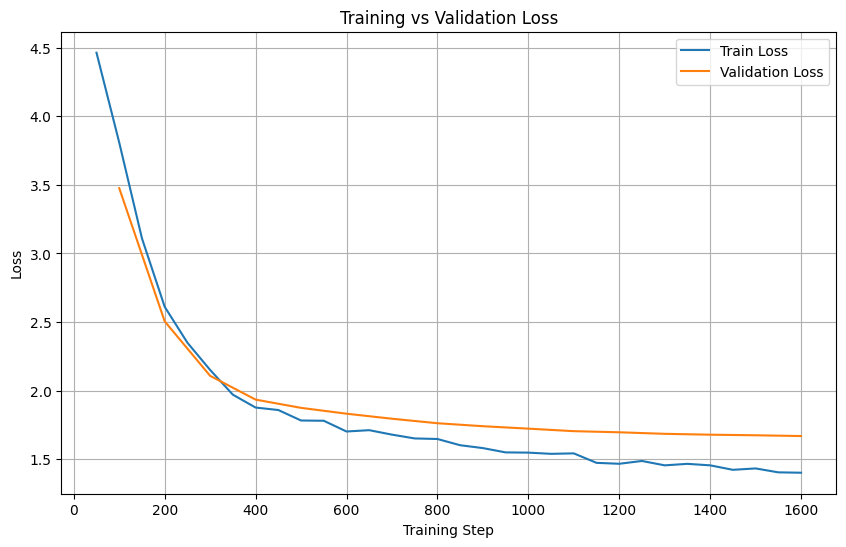

In [ ]:
# Path to your trainer_state.json
state_path ="/content/drive/MyDrive/Dl_project/Gemma/Gemma_models/no_cot_model/checkpoint-1600/trainer_state.json"

# Load JSON
with open(state_path, "r") as f:
    state = json.load(f)

# Extract log history
logs = state["log_history"]
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []

for entry in logs:
    # Training loss entries
    if "loss" in entry and "epoch" in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])

    # Evaluation loss entries
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])

# Plot 
plt.figure(figsize=(10,6))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Validation Loss")

plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Models M prometheus Comparison

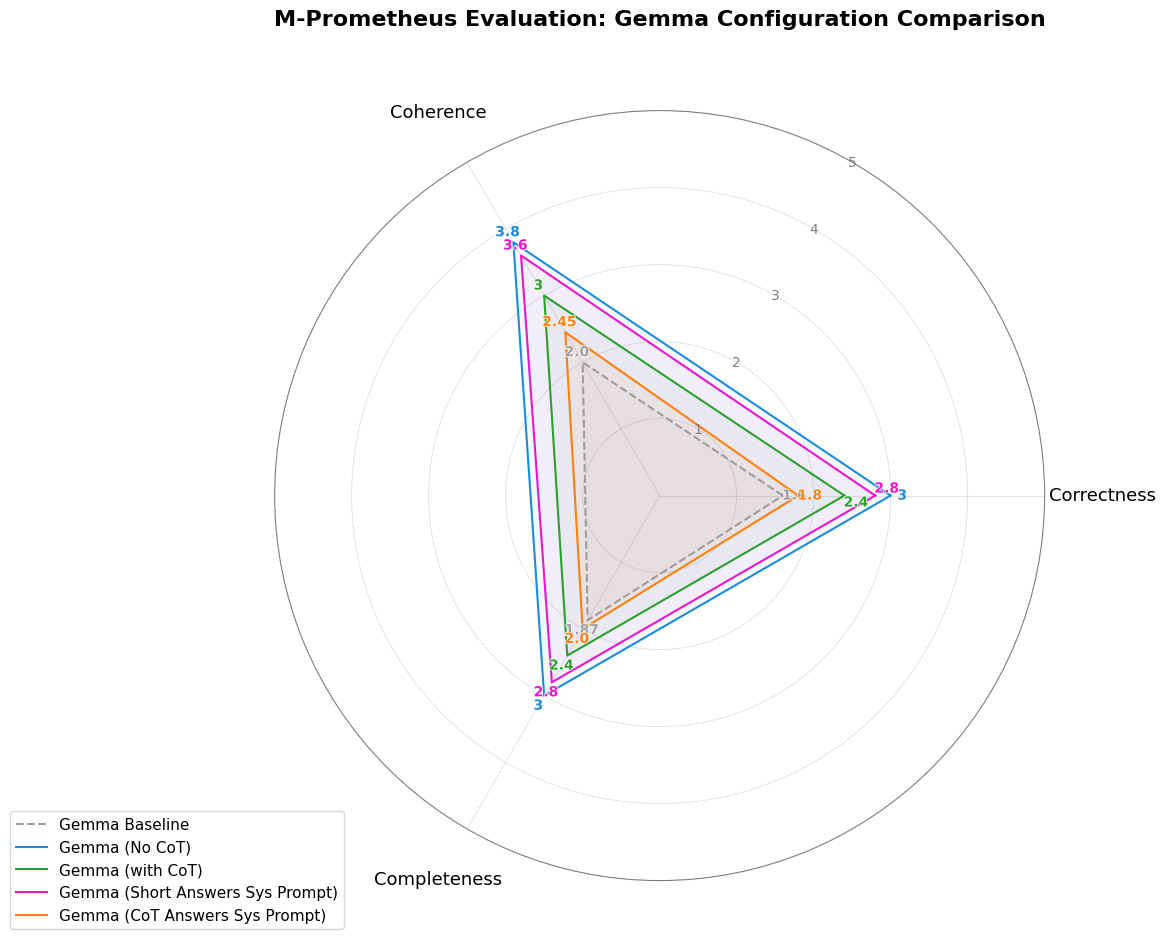

In [ ]:
# DATA SETUP
categories = ['Correctness', 'Coherence', 'Completeness']
N = len(categories)

scores = {
    "Gemma Baseline": [1.6, 2.0, 1.87],
    "Gemma (No CoT)": [3, 3.8, 3],
    "Gemma (with CoT)": [2.4, 3, 2.4],
    "Gemma (Short Answers Sys Prompt)": [2.8, 3.6, 2.8],
    "Gemma (CoT Answers Sys Prompt)": [1.8, 2.45, 2.0]
}

# RADAR CHART FUNCTION
def make_radar_chart():
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, color='black', size=13)

    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        angle_deg = np.degrees(angle)
        label.set_rotation(angle_deg)
        label.set_rotation_mode('anchor')
        label.set_y(label.get_position()[1] - 0.1)

    ax.set_yticklabels([])

    for r in [1, 2, 3, 4, 5]:
        ax.text(np.pi / 3, r, str(r), color="grey", size=10,
                ha="center", va="center")

    plt.ylim(0, 5)

    colors = ["#9e9e9e", "#1e8bda", "#2ca02c", "#E717CE", "#ff7f0e"]

    for idx, (label, values) in enumerate(scores.items()):
        values_loop = values + values[:1]

        ax.plot(
            angles,
            values_loop,
            linewidth=1.5,
            linestyle='--' if 'Baseline' in label else 'solid',
            label=label,
            color=colors[idx]
        )

        ax.fill(angles, values_loop, color=colors[idx], alpha=0.05)

        for i, val in enumerate(values):
            va_align = 'center'

            if i == 0:
                if label == "Gemma (Short Answers Sys Prompt)":
                    va_align = 'bottom'
                elif label == "Gemma (with CoT)":
                    va_align = 'top'

            txt = ax.text(
                angles[i],
                val + 0.15,
                str(val),
                color=colors[idx],
                size=10,
                weight='bold',
                ha='center',
                va=va_align
            )

            txt.set_path_effects([
                path_effects.Stroke(linewidth=1, foreground='white'),
                path_effects.Normal()
            ])

    ax.yaxis.grid(True, color='gray', alpha=0.25, linewidth=0.6)
    ax.xaxis.grid(True, color='gray', alpha=0.25, linewidth=0.6)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=11)
    plt.title(
        'M-Prometheus Evaluation: Gemma Configuration Comparison',
        size=16,
        weight='bold',
        y=1.1
    )

    ax.spines['polar'].set_color('grey')
    plt.show()

make_radar_chart()


### Correlation Analysis between ROUGE and M Prometheus Correctness Scores

📂 Loading files...
⚙️ Aligning data points...
📊 Correlation Coefficient (r): 0.1098


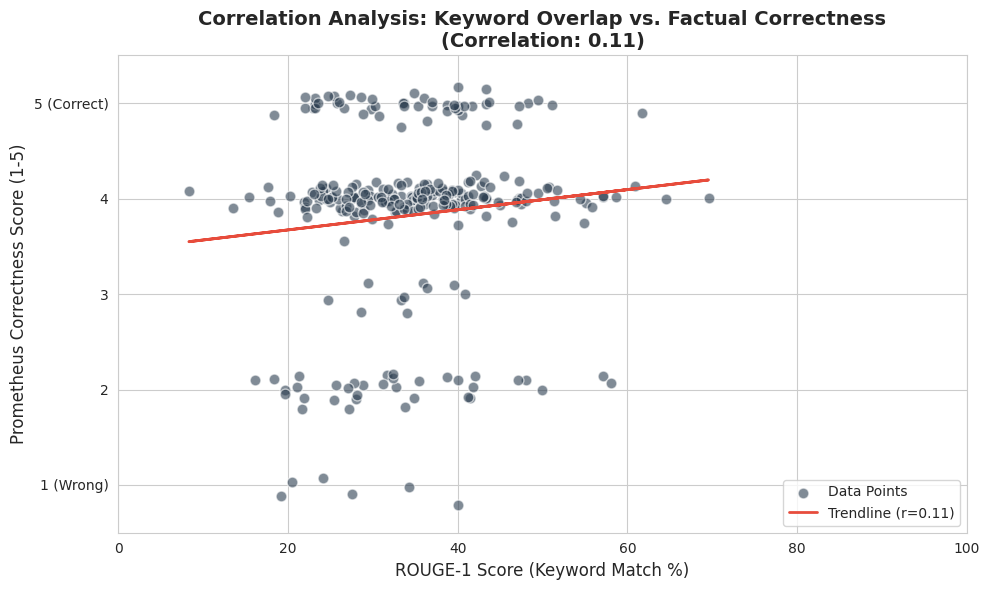

In [ ]:
# CONFIG
FILE_WITH_ROUGE = "test_no_cot_with_rouge_scores.json"
FILE_WITH_PROMETHEUS = "turkish_evaluation_results_NO_cot.json"

# LOAD & MERGE DATA
print("Loading files...")

try:
    with open(FILE_WITH_ROUGE, 'r', encoding='utf-8') as f:
        rouge_data = json.load(f)
    with open(FILE_WITH_PROMETHEUS, 'r', encoding='utf-8') as f:
        prom_data = json.load(f)
except FileNotFoundError:
    print("Error: Files not found. Please check filenames.")


# Extract Data Points
x_rouge = []
y_prometheus = []

print("Aligning data points...")

min_len = min(len(rouge_data), len(prom_data))

for i in range(min_len):
    r_score = rouge_data[i].get('rouge1', 0)
    if r_score <= 1.0: r_score *= 100  # Normalize to 0-100

    # Get Prometheus
    p_score = prom_data[i].get('coherence_score', None)

    if p_score is not None:
        x_rouge.append(r_score)
        y_prometheus.append(p_score)

# STATISTICAL ANALYSIS
# Calculate Pearson Correlation
corr, _ = pearsonr(x_rouge, y_prometheus)
print(f"Correlation Coefficient (r): {corr:.4f}")

# PLOT VISUALIZATION
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

y_jittered = np.array(y_prometheus) + np.random.normal(0, 0.1, size=len(y_prometheus))

# Scatter Plot
plt.scatter(x_rouge, y_jittered, alpha=0.6, color='#2c3e50', edgecolor='w', s=60, label='Data Points')

# Trendline 
m, b = np.polyfit(x_rouge, y_prometheus, 1)
plt.plot(x_rouge, m*np.array(x_rouge) + b, color='#e74c3c', linewidth=2, label=f'Trendline (r={corr:.2f})')

# Formatting
plt.title(f'Correlation Analysis: Keyword Overlap vs. Factual Correctness\n(Correlation: {corr:.2f})', fontsize=14, weight='bold')
plt.xlabel('ROUGE-1 Score (Keyword Match %)', fontsize=12)
plt.ylabel('Prometheus Correctness Score (1-5)', fontsize=12)
plt.yticks([1, 2, 3, 4, 5], ['1 (Wrong)', '2', '3', '4', '5 (Correct)'])
plt.xlim(0, 100)
plt.ylim(0.5, 5.5)
plt.legend(loc='lower right')

# Save
plt.tight_layout()
plt.savefig('rouge_vs_prometheus_correlation.png', dpi=300)
plt.show()

We observed a divergence (r=0.11) between n-gram overlap metrics (ROUGE) and semantic evaluation (Prometheus). This indicates that the fine-tuned model successfully learned to generalize and paraphrase biological concepts rather than merely memorizing training data. It validates the necessity of using LLM-based evaluation for complex, agglutinative languages like Turkish, where correct answers can vary significantly in surface-level wording."

## Feature Representation

Using device: cuda
Loading model...
Loading data from /content/drive/MyDrive/Dl_ project/Dataset/Dataset_after_updating_cot/new_cot_formatted_data/test_messages_new_cot.json...
Using column: 'messages'
Successfully processed 834 samples.
Sample input 0: user: Canlı organizmaların yaklaşık %96'sını oluşturan dört temel element nelerdir? 
assistant: Canl...


Extracting Embeddings: 100%|██████████| 105/105 [00:10<00:00, 10.02it/s]


Clustering into 5 groups...
Running t-SNE...
Plot saved as 'cluster_analysis.png'


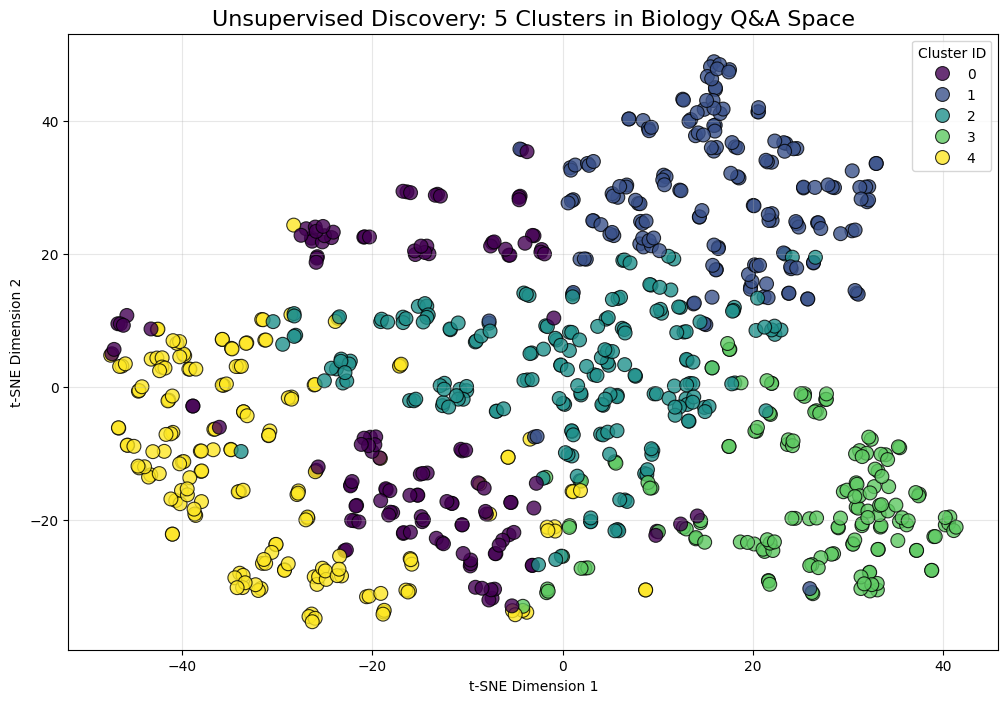


--- CLUSTER INTERPRETATION ---

Cluster 0 Samples:
  - [{'role': 'user', 'content': 'Bir süreçteki başlangıç etkisini artırarak devam ettiren pozitif geri besleme döngüsü nasıl tanımlanır?'}, {'role': 'assistant', 'content': 'Pozitif geri bildirim döngüsü, bir sistemde meydana gelen değişikliği daha da güçlendirerek veya artırarak süreci ilerleten ve hızlandıran bir mekanizmadır. Bu döngüler, genellikle kısa süreli ve belirli bir hedefe yönelik olayların (örneğin, kan pıhtılaşması veya doğum) tamamlanması için kullanılır, çünkü başlangıç sinyalini sürekli olarak artırır.'}]...
  - [{'role': 'user', 'content': 'Dünya üzerindeki biyolojik çeşitliliğin ani ve dramatik bir şekilde azaldığı dönemlere ne isim verilir?'}, {'role': 'assistant', 'content': 'Dünya tarihinde beş kez gerçekleşen ve türlerin çeşitliliğinde keskin bir düşüşe yol açan dönemlerdir. Bu olaylar, normal arka plan yok oluş oranlarının çok üzerine çıkar ve ekosistemlerde büyük boşluklar yaratır.'}]...
  - [{'role': 'user'

In [ ]:
#  CONFIG
MODEL_PATH = "/content/drive/MyDrive/Dl_ project/Gemma/Gemma_models/no_cot_model/checkpoint-2400"
DATA_PATH = "/content/drive/MyDrive/Dl_ project/Dataset/Dataset_after_updating_cot/new_cot_formatted_data/test_messages_new_cot.json"

# Number of clusters to find (5 for broad topics)
NUM_CLUSTERS = 5

# samples to plot 
NUM_SAMPLES = 1000

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# LOAD MODEL & TOKENIZER
print("Loading model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForCausalLM.from_pretrained(MODEL_PATH, torch_dtype=torch.float16).to(device)
model.eval()

# Ensure tokenizer has a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# LOAD DATA
print(f"Loading data from {DATA_PATH}...")

# Read the file
if DATA_PATH.endswith('.json'):
    df = pd.read_json(DATA_PATH)
else:
    df = pd.read_csv(DATA_PATH)

if 'messages' in df.columns:
    text_col = 'messages'
elif 'question' in df.columns:
    text_col = 'question'
else:
    text_col = df.columns[0]

print(f"Using column: '{text_col}'")

texts = []
raw_data = df[text_col].head(NUM_SAMPLES).tolist()

for item in raw_data:
    if isinstance(item, str):
        texts.append(item)

    elif isinstance(item, list):
        extracted_text = ""
        for msg in item:
            if isinstance(msg, dict) and 'content' in msg:
                extracted_text += f"{msg.get('role', '')}: {msg['content']} \n"

        if extracted_text.strip():
            texts.append(extracted_text)
        else:
            texts.append(str(item))

    elif isinstance(item, dict):
        texts.append(json.dumps(item, ensure_ascii=False))

    else:
        texts.append("empty")

print(f"Successfully processed {len(texts)} samples.")
print(f"Sample input 0: {texts[0][:100]}...")

# EXTRACT EMBEDDINGS
def get_embeddings(text_list, batch_size=8):
    all_embeddings = []

    for i in tqdm(range(0, len(text_list), batch_size), desc="Extracting Embeddings"):
        batch_texts = text_list[i:i+batch_size]

        # Tokenize
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

            hidden_states = outputs.hidden_states[-1]

            # Strategy: Mean Pooling (Average of all tokens to get one vector per sentence)
            # Mask padding tokens so they don't affect average
            attention_mask = inputs['attention_mask'].unsqueeze(-1)
            masked_embeddings = hidden_states * attention_mask
            sum_embeddings = masked_embeddings.sum(dim=1)
            token_counts = attention_mask.sum(dim=1).clamp(min=1e-9)
            mean_embeddings = sum_embeddings / token_counts

            all_embeddings.append(mean_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)

embeddings = get_embeddings(texts)

# CLUSTERING (K-MEANS)
print(f"Clustering into {NUM_CLUSTERS} groups...")
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# DIMENSIONALITY REDUCTION (t-SNE) We also tried PCA but noticed that t-sne results are better so we used it.
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=min(30, len(texts)-1), random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(embeddings)

# PLOTTING
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x=vis_dims[:, 0],
    y=vis_dims[:, 1],
    hue=cluster_labels,
    palette="viridis",
    s=100,
    alpha=0.8,
    edgecolor='k'
)

plt.title(f"Unsupervised Discovery: {NUM_CLUSTERS} Clusters in Biology Q&A Space", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster ID")
plt.grid(True, alpha=0.3)

# SAVE PLOT
plt.savefig("cluster_analysis.png")
print("Plot saved as 'cluster_analysis.png'")
plt.show()

# INTERPRETATION 
print("\n--- CLUSTER INTERPRETATION ---")
df_subset = df.head(len(texts)).copy()
df_subset['cluster'] = cluster_labels

for i in range(NUM_CLUSTERS):
    print(f"\nCluster {i} Samples:")
    # Print 3 random examples from this cluster
    examples = df_subset[df_subset['cluster'] == i][text_col].sample(min(3, len(df_subset[df_subset['cluster'] == i]))).values
    for ex in examples:
        print(f"  - {ex[:100]}...") # Truncate long text

In [ ]:
# Silhouette Score (Ranges from -1 to 1) -> Higher is Better
sil_score = silhouette_score(embeddings, cluster_labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Davies-Bouldin Index (Ranges from 0 to infinity) -> Lower is Better
db_score = davies_bouldin_score(embeddings, cluster_labels)
print(f"Davies-Bouldin Score: {db_score:.3f}")

Silhouette Score: 0.085
Davies-Bouldin Score: 2.698


In [ ]:
def calculate_perplexity(model, tokenizer, text_list, max_length=512):
    # Set model to evaluation mode
    model.eval()

    total_loss = 0.0
    total_steps = 0

    # We process one sample at a time for accuracy
    print("Calculating Perplexity...")
    with torch.no_grad():
        for text in tqdm(text_list):
            # Tokenize input
            # We set labels=input_ids because the model tries to predict its own input
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length).to(device)
            input_ids = inputs["input_ids"]

            # Get the Loss
            # HuggingFace models return loss automatically if 'labels' are provided
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss

            # Accumulate
            if not torch.isnan(loss):
                total_loss += loss.item()
                total_steps += 1

    # Calculate Average Loss & Perplexity
    if total_steps == 0:
        return float('inf')

    avg_loss = total_loss / total_steps
    perplexity = math.exp(avg_loss)

    return perplexity

ppl_score = calculate_perplexity(model, tokenizer, texts[:100]) # Test on first 100 samples to save time
print(f"\nModel Perplexity: {ppl_score:.2f}")

Calculating Perplexity...


100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Model Perplexity: 10.68
